## looking into susie 1 var cs
pecotmr funcitons are supposed to help with this

1. run susie the old way and get 1 var cs
2. run with the new way, confirm they disapear
3. work it into the main script

In [1]:
setwd('/home/klawren/oak/pcqtls/')
library(coloc)
library(nanoparquet)
library(tidyverse)
library(data.table)
library(Rfast)
library(argparse)
library(tidyverse)
library(susieR)
library(pecotmr)

This is coloc version 5.2.3

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The foll

In [59]:
source("workflow/scripts/coloc_functions.R")

In [19]:
# test args for debugging
eqtl_dir_path <- 'output/proteincoding_main/control_eqtl/Thyroid'
pcqtl_dir_path <- 'output/proteincoding_main/pcqtl/Thyroid'
gwas_meta_path <- '/home/klawren/oak/pcqtls/data/references/gwas_metadata.txt'
gtex_meta_path <- '/home/klawren/oak/pcqtls/data/references/gtex_sample_sizes.csv'
tissue_id <- 'Thyroid'
ld_path_head <- 'output/proteincoding_main/gwas_coloc/temp/'
genotype_stem <- "data/processed/genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01"
gwas_path <- '/oak/stanford/groups/smontgom/shared/gwas_summary_stats/barbeira_gtex_imputed/imputed_gwas_hg38_1.1/imputed_UKB_20002_1461_self_reported_inflammatory_bowel_disease.txt.gz'
output_path <- 'output/temp/test_coloc.txt'
gwas_id <- 'UKB_20002_1461_self_reported_inflammatory_bowel_disease'
annotated_cluster_path <- 'output/proteincoding_main/annotations/Thyroid_clusters_annotated.csv'
gwas_temp_path_head <- 'output/proteincoding_main/gwas_coloc/Thyroid/temp/'
use_susie <- TRUE

# one with a gwas signal overlap
cluster_id <-'ENSG00000129151.8_ENSG00000176971.3'
i <- 52
chr_id <- 11

# one with a susie we can load
cluster_id <- 'ENSG00000001626.14_ENSG00000077063.10'
chr_id <- 7
i <- 10
susie_path <- "output/proteincoding_main/gwas_coloc/Thyroid/temp/ENSG00000001626.14_ENSG00000077063.10_e_ENSG00000077063.10.susie.rds"


chr_id <- 8
i <- 29
cluster_id <- 'ENSG00000003987.13_ENSG00000003989.17'
susie_path <- 'output/proteincoding_main/gwas_coloc/Thyroid/temp/ENSG00000003987.13_ENSG00000003989.17_e_ENSG00000003989.17.susie.rds'


load in the qtl and gwas data

In [4]:
start <- Sys.time()

# read in gtex meta to get sample size
gtex_meta <- read.table(gtex_meta_path, sep='\t', header = T)
num_gtex_samples <- gtex_meta[gtex_meta$tissue_id == tissue_id, 'sample_size']

# load in clusters
cluster_df <- fread(annotated_cluster_path)

load in data for this cluster

In [7]:
# get the gwas data for this chr
cluster_df_chr <- cluster_df[cluster_df$Chromosome == chr_id]

# get the qtl data
eqtl_chr <- get_eqtl_chr(eqtl_dir_path, chr_id, tissue_id)
pcqtl_chr <- get_pcqtl_chr(pcqtl_dir_path, chr_id, tissue_id)

# pull out the cluster
this_cluster <- cluster_df_chr[i]
cluster_id <- this_cluster$cluster_id

# subset eqtl and pcqtl to this cluster
cluster_eqtl <-eqtl_chr[eqtl_chr$cluster_id == cluster_id, ]
cluster_pcqtl <- pcqtl_chr[pcqtl_chr$cluster_id == cluster_id, ]

# get snp list and ld matrix
snp_list <- get_snp_list(cluster_eqtl, ld_path_head, cluster_id)
cleaned_ld_matrix <- get_ld(ld_path_head, cluster_id, snp_list, genotype_stem)
ld_snp_set <- rownames(cleaned_ld_matrix)


snp list already exists
12865  snps found for this cluster
ld matrix already exists
total working snps:  12449 


In [8]:
# clean the eqtl and pcqtl data into the right format for susie
eqtls_for_coloc <- split_qtl_for_coloc(cluster_eqtl, ld_snp_set, cleaned_ld_matrix, num_gtex_samples)
pcqtls_for_coloc <- split_qtl_for_coloc(cluster_pcqtl, ld_snp_set, cleaned_ld_matrix, num_gtex_samples)
# combine them into one list
qtls_for_coloc <- c(eqtls_for_coloc, pcqtls_for_coloc)
qtls_for_coloc <- qtls_for_coloc[!sapply(qtls_for_coloc, is.null)]

	looking for signals in ENSG00000003987.13_ENSG00000003989.17_e_ENSG00000003987.13 
		qtl filtered to : 12449 snps
		Number snps with  qtl missing:  0 
		signal found 
	looking for signals in ENSG00000003987.13_ENSG00000003989.17_e_ENSG00000003989.17 
		qtl filtered to : 12449 snps
		Number snps with  qtl missing:  0 
		signal found 
	looking for signals in ENSG00000003987.13_ENSG00000003989.17_pc1 
		qtl filtered to : 12449 snps
		Number snps with  qtl missing:  0 
		signal found 
	looking for signals in ENSG00000003987.13_ENSG00000003989.17_pc2 
		qtl filtered to : 12449 snps
		Number snps with  qtl missing:  0 
		signal found 


load in old susie

In [9]:
old_susie <-  readRDS(file = susie_path)
summary(old_susie)$cs

cs,cs_log10bf,cs_avg_r2,cs_min_r2,variable
<int>,<dbl>,<dbl>,<dbl>,<chr>
1,Inf,1,1,6247
2,Inf,1,1,6212
3,Inf,1,1,6216
4,Inf,1,1,6238
5,Inf,1,1,6172
6,Inf,1,1,6112
7,Inf,1,1,6105
9,Inf,1,1,"6231,6239,6240"


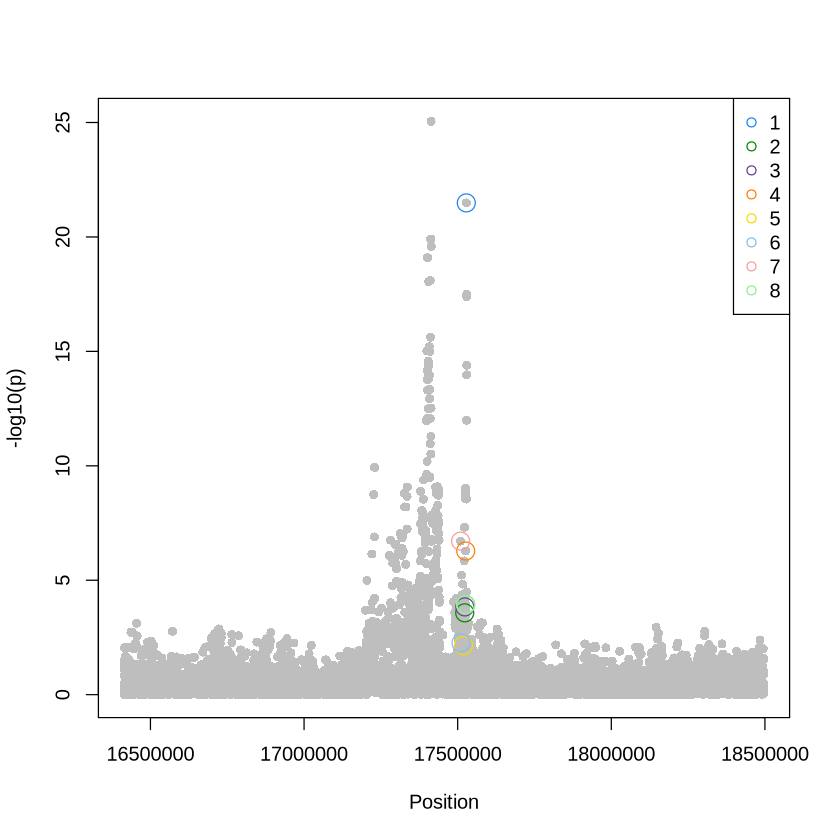

In [11]:
old_qtl <- qtls_for_coloc[[1]]
plot_dataset(old_qtl, susie_obj=old_susie)

[1] 0.5286905

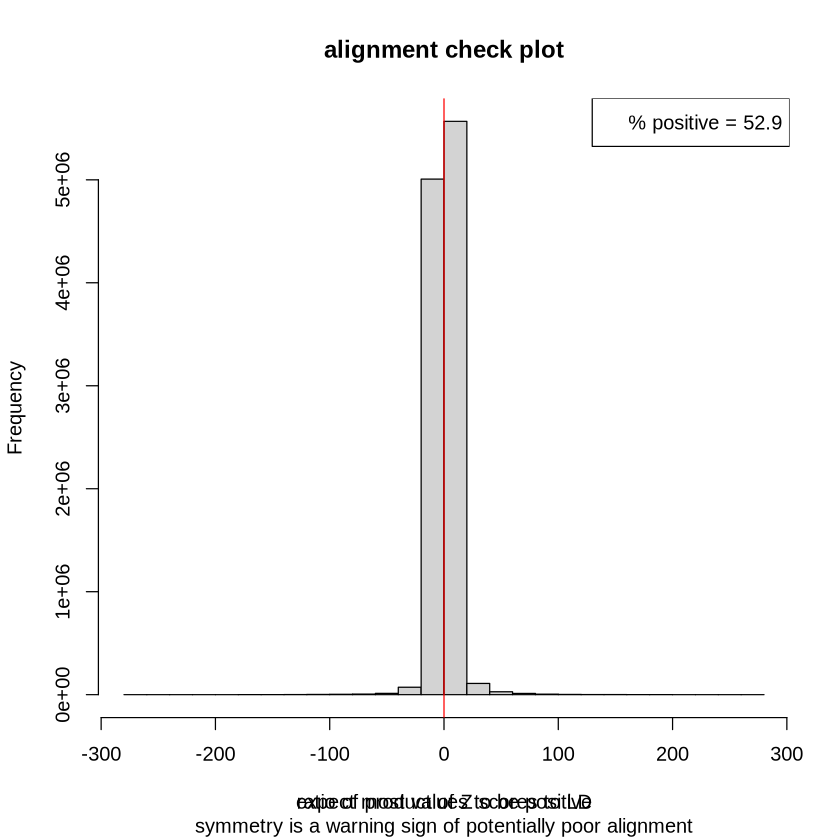

In [12]:
check_alignment(old_qtl)

In [13]:
# run the rss qc
# from the pecotmr docs "'z' is calculated as 'beta' divided by 'se'"
rss_df <- data.frame(
    variant_id = old_qtl$snp, 
    z = old_qtl$beta/sqrt(old_qtl$varbeta),
    pos = old_qtl$position
)

rss_result <- susie_rss_qc(rss_df, old_qtl$LD, n=num_gtex_samples, var_y=1)

Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf repl

[1] 0.5286023

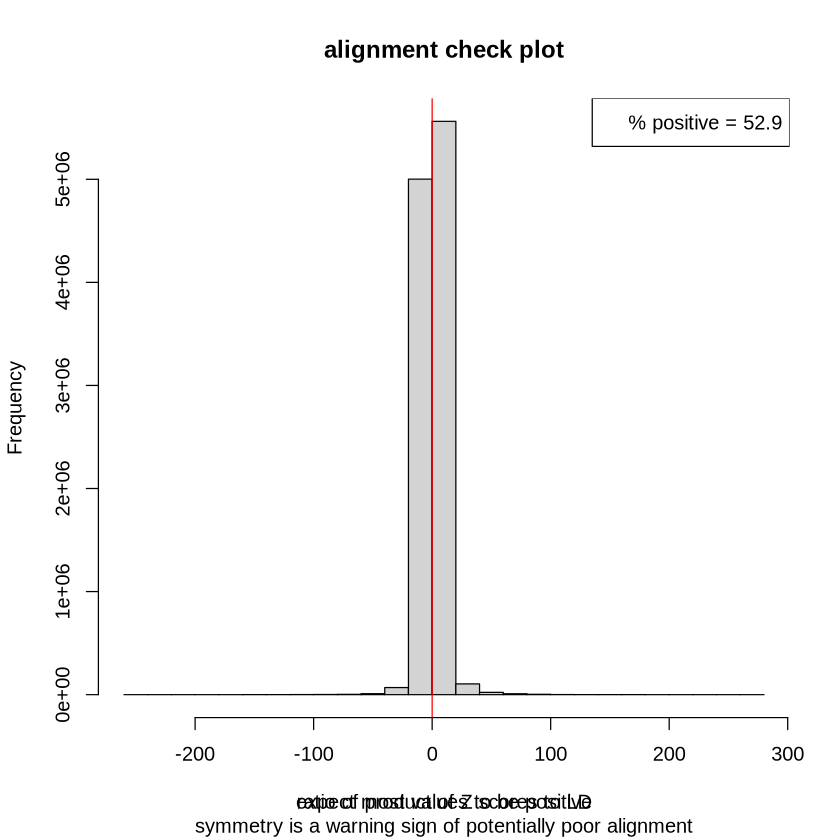

In [15]:
# check the alrignment now with the fixed LD and z
bprod=outer(rss_result$sumstats$z,rss_result$sumstats$z,"*")
tmp=(bprod/rss_result$LD_mat)[abs(rss_result$LD_mat) > 0.2]
hist(tmp,
       xlab="ratio of product of Z scores to LD",
       main="alignment check plot",
       sub="expect most values to be positive\nsymmetry is a warning sign of potentially poor alignment")
legend("topright",legend=paste0("% positive = ",100*round(mean( tmp > 0 ),3)))
abline(v=0,col="red")
mean(tmp > 0)

In [16]:
# run the susie_rss_pipeline on the susie_rss_qc result?
allele_flip = allele_qc(rss_result$sumstats$variant, rss_result$LD_mat, rss_result$sumstats, match_min_prop=0.2, remove_dups=FALSE, flip_strand=TRUE)
head(allele_flip)

ERROR: Error: object 'LD_data' not found


In [ ]:
# try if following this: https://github.com/cumc/pecotmr/blob/3a4b7ad279c84a66dc47d006a4f222a8ba21d45d/vignettes/susie-rss-qc.Rmd

load in gwas

In [31]:
# load in one gwas (specified)
gwas_meta_df <- fread(gwas_meta_path)
gwas_with_meta <- load_gwas_from_path(gwas_path, gwas_meta_df, gwas_id)
gwas_data <- gwas_with_meta$gwas_data
cat("total gwas signals", sum(gwas_data$pvalue < 1e-6), "\n")

# get snp list and ld matrix
snp_list <- get_snp_list(cluster_eqtl, ld_path_head, cluster_id)
cleaned_ld_matrix <- get_ld(ld_path_head, cluster_id, snp_list, genotype_stem)
ld_snp_set <- rownames(cleaned_ld_matrix)

gwas_chr <- gwas_with_meta$gwas_data[gwas_with_meta$gwas_data$chromosome == paste('chr', chr_id, sep="")] 

# is there an overlapping signal here?
check_gwas_cluster(gwas_chr, this_cluster)

		reading gwas: 22.5459894855817 
		finished reading gwas: 22.811446472009 
total gwas signals 156 
snp list already exists
12865  snps found for this cluster
ld matrix already exists
total working snps:  12449 


[1] TRUE

snps in gwas: 10680
	 Number snps with ld or gwas missing:  3045 
	 signal found 


[1] 0.535537

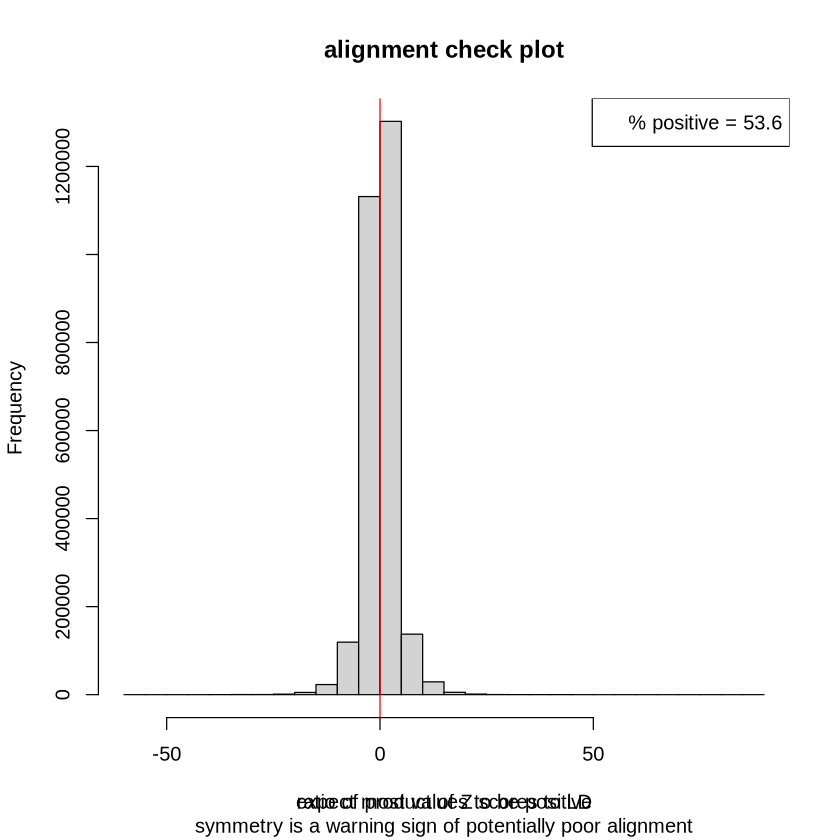

In [64]:
# clean the gwas data into the right format for susie
gwas_for_coloc <- get_gwas_for_coloc(gwas_with_meta, ld_snp_set, snp_list, cleaned_ld_matrix)
check_alignment(gwas_for_coloc)